In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


In [3]:
# Data Loading
data_path=r"C:\Users\shali\OneDrive\Desktop\EXCEL\Capstone\Ecommerce"

In [4]:
# Load CSVs
orders = pd.read_csv(f"{data_path}/orders.csv")
order_items = pd.read_csv(f"{data_path}/order_items.csv")
customers = pd.read_csv(f"{data_path}/customers.csv")
products = pd.read_csv(f"{data_path}/products.csv")
sellers = pd.read_csv(f"{data_path}/sellers.csv")

print("Data loaded")

Data loaded


In [5]:
# Convert date columns in 'orders' to datetime
date_columns = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

for col in date_columns:
    orders[col] = pd.to_datetime(orders[col], errors='coerce')  # Use errors='coerce' to handle invalid entries safely
orders['order_id'].nunique()

# Convert date columns in 'order_items' to datetime
order_items['shipping_limit_date'] = pd.to_datetime(order_items['shipping_limit_date'], errors='coerce')


In [6]:
# Check for unique identifiers
print("Unique order IDs in orders:", orders['order_id'].nunique())
print("Unique order IDs in order_items:", order_items['order_id'].nunique())

print("Unique customer IDs in orders:", orders['customer_id'].nunique())
print("Unique customer IDs in customers:", customers['customer_id'].nunique())

print("Unique product IDs in order_items:", order_items['product_id'].nunique())
print("Unique product IDs in products:", products['product_id'].nunique())

print("Unique seller IDs in order_items:", order_items['seller_id'].nunique())
print("Unique seller IDs in sellers:", sellers['seller_id'].nunique())

Unique order IDs in orders: 99441
Unique order IDs in order_items: 98666
Unique customer IDs in orders: 99441
Unique customer IDs in customers: 99441
Unique product IDs in order_items: 32951
Unique product IDs in products: 32951
Unique seller IDs in order_items: 3095
Unique seller IDs in sellers: 3095


In [7]:
##Sales & Customer Forecasting

#sales data
sales_data = pd.merge(orders, order_items, on='order_id')  #creates a new DataFrame by joining orders and order_items 
#Creates a new column containing just the year and month stored as a Period object
sales_data['order_date'] = sales_data['order_purchase_timestamp'].dt.to_period('M')
#Returns a new DataFrame monthly_sales with two columns:order_date & price
monthly_sales = sales_data.groupby('order_date')['price'].sum().reset_index()
#Converts Period objects back into full timestamp format
monthly_sales['order_date'] = monthly_sales['order_date'].dt.to_timestamp()
monthly_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   order_date  24 non-null     datetime64[ns]
 1   price       24 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 516.0 bytes


22:35:26 - cmdstanpy - INFO - Chain [1] start processing
22:35:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\shali\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


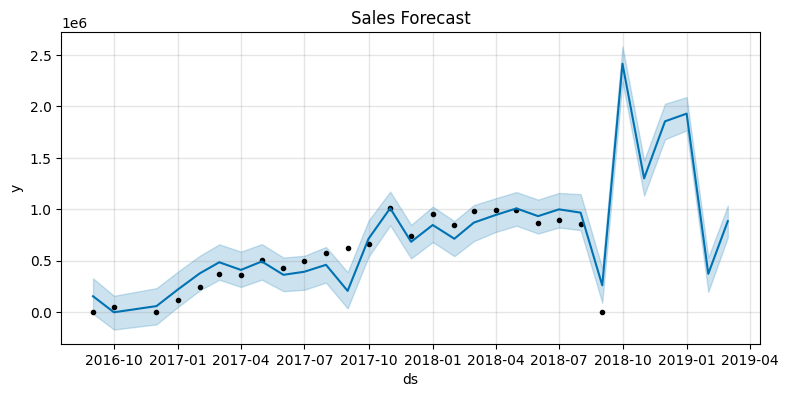

In [10]:
from prophet import Prophet

# Rename columns
monthly_sales.columns = ['ds', 'y']

# Fit model
model = Prophet()
model.fit(monthly_sales)

# Future dataframe
future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)

# Plot
model.plot(forecast,figsize=(8,4))
plt.title("Sales Forecast")
plt.show()

In [11]:
#new customer
orders['order_month'] = orders['order_purchase_timestamp'].dt.to_period('M')
new_customers_monthly = orders.groupby('order_month')['customer_id'].nunique().reset_index()
new_customers_monthly.columns = ['ds', 'y']
new_customers_monthly['ds'] = new_customers_monthly['ds'].dt.to_timestamp()

22:39:22 - cmdstanpy - INFO - Chain [1] start processing
22:39:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\shali\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


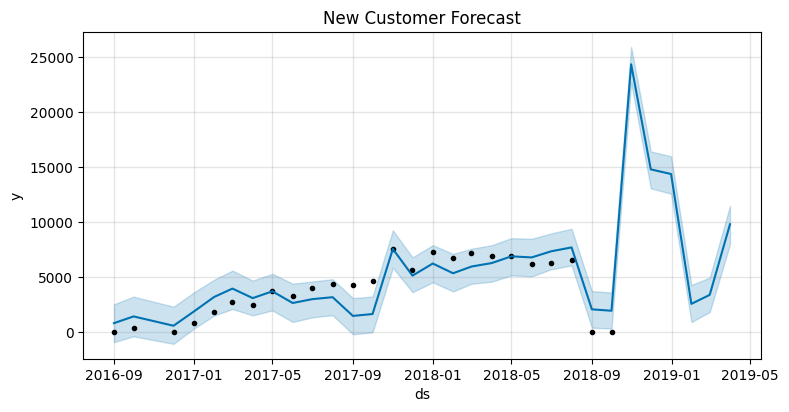

In [12]:
# Prophet
customer_model = Prophet()
customer_model.fit(new_customers_monthly)

future_customers = customer_model.make_future_dataframe(periods=6, freq='M')
customer_forecast = customer_model.predict(future_customers)

customer_model.plot(customer_forecast,figsize=(8,4))
plt.title("New Customer Forecast")
plt.show()

In [15]:
## Customer Segmentation

#create RFM 

#one day after the last purchase date, reference point for calculating Recency
snapshot_date = orders['order_purchase_timestamp'].max() + pd.Timedelta(days=1) 

#DataFrame rfm with columns: customer_id, recency (days since last purchase), and frequency (number of orders).
rfm = orders.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'count'
}).reset_index()

#calculate total money spent by each customer.
monetary = pd.merge(order_items, orders[['order_id', 'customer_id']], on='order_id')

#DataFrame with each customer’s total monetary value.
monetary = monetary.groupby('customer_id')['price'].sum().reset_index()

#contains all three RFM metrics: Recency, Frequency, and Monetary.
rfm = pd.merge(rfm, monetary, on='customer_id')
rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']
rfm

,customer_id,Recency,Frequency,Monetary
0,00012a2ce6f8dcda20d059ce98491703,338,1,89.80
1,000161a058600d5901f007fab4c27140,459,1,54.90
2,0001fd6190edaaf884bcaf3d49edf079,597,1,179.99
3,0002414f95344307404f0ace7a26f1d5,428,1,149.90
4,000379cdec625522490c315e70c7a9fb,199,1,93.00
...,...,...,...,...
98661,fffcb937e9dd47a13f05ecb8290f4d3e,215,1,78.00
98662,fffecc9f79fd8c764f843e9951b11341,203,1,54.90
98663,fffeda5b6d849fbd39689bb92087f431,149,1,47.90
98664,ffff42319e9b2d713724ae527742af25,127,1,199.90


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# normalize RFM value

rfm_clustering = rfm[['Recency', 'Frequency', 'Monetary']].copy()   #Copy for clustering

# Scale using StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_clustering)

# Applying KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Average RFM per cluster
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)
print(cluster_summary)


# label the cluster
def label_segment(row):
    if row['Cluster'] == 3:
        return 'Loyal High-Value Customers'
    elif row['Cluster'] == 0:
        return 'Potential Loyalist'
    elif row['Cluster'] == 2:
        return 'Discount-Seeker'
    elif row['Cluster'] == 1:
        return 'Churn Risk'

rfm['Segment'] = rfm.apply(label_segment, axis=1)
rfm

         Recency  Frequency  Monetary
Cluster                              
0          440.4        1.0     102.8
1          179.1        1.0     101.9
2          285.1        1.0     649.6
3          289.2        1.0    1974.2


,customer_id,Recency,Frequency,Monetary,Cluster,Segment
0,00012a2ce6f8dcda20d059ce98491703,338,1,89.80,0,Potential Loyalist
1,000161a058600d5901f007fab4c27140,459,1,54.90,0,Potential Loyalist
2,0001fd6190edaaf884bcaf3d49edf079,597,1,179.99,0,Potential Loyalist
3,0002414f95344307404f0ace7a26f1d5,428,1,149.90,0,Potential Loyalist
4,000379cdec625522490c315e70c7a9fb,199,1,93.00,1,Churn Risk
...,...,...,...,...,...,...
98661,fffcb937e9dd47a13f05ecb8290f4d3e,215,1,78.00,1,Churn Risk
98662,fffecc9f79fd8c764f843e9951b11341,203,1,54.90,1,Churn Risk
98663,fffeda5b6d849fbd39689bb92087f431,149,1,47.90,1,Churn Risk
98664,ffff42319e9b2d713724ae527742af25,127,1,199.90,1,Churn Risk


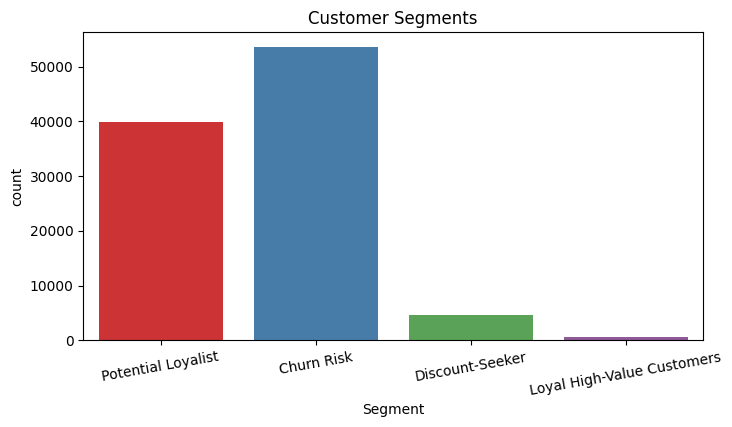

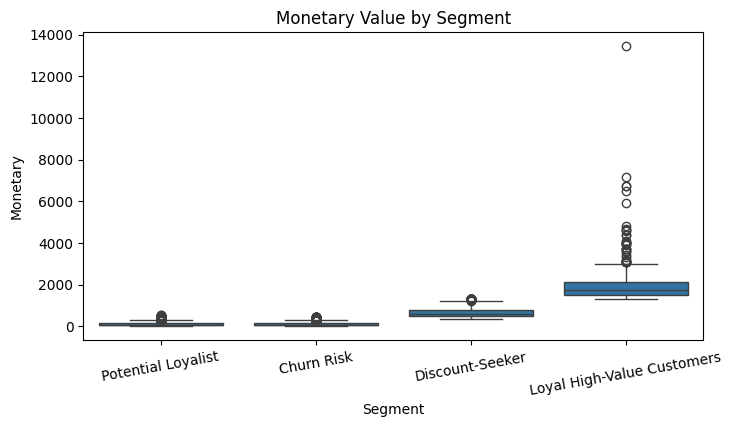

In [19]:
# count of customers per segment
plt.figure(figsize=(8, 4))
sns.countplot(data=rfm, x='Segment',hue='Segment',palette="Set1")
plt.xticks(rotation=10)
plt.title("Customer Segments")
plt.show()

# RFM distribution per show
plt.figure(figsize=(8, 4))
sns.boxplot(data=rfm, x='Segment', y='Monetary')
plt.xticks(rotation=10)
plt.title("Monetary Value by Segment")
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27846
           1       1.00      1.00      1.00      5949

    accuracy                           1.00     33795
   macro avg       1.00      1.00      1.00     33795
weighted avg       1.00      1.00      1.00     33795



<Figure size 600x600 with 0 Axes>

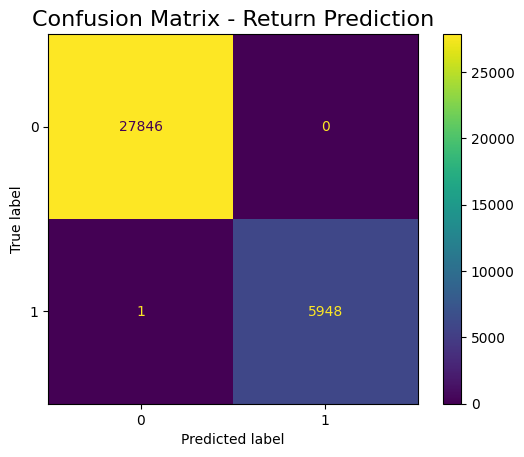

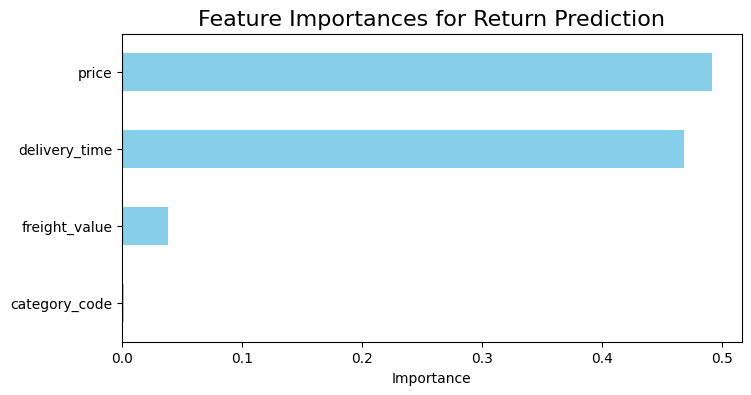

In [20]:
## Return Prediction

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

facts = (order_items.merge(orders[["order_id","customer_id","order_purchase_timestamp",
                                   "order_delivered_customer_date"]], on="order_id", how="left")
                   .merge(products[["product_id","product_category"]], on="product_id", how="left"))

facts["delivery_time"] = (pd.to_datetime(facts["order_delivered_customer_date"]) -
                          pd.to_datetime(facts["order_purchase_timestamp"])).dt.days
facts["delivery_time"] = facts["delivery_time"].fillna(facts["delivery_time"].median())

if "is_returned" in facts.columns:
    facts["target"] = facts["is_returned"]
else:
    np.random.seed(42)
    facts["target"] = np.where((facts["delivery_time"]>10) & (facts["price"]>100),1,0)

X = facts[["price","delivery_time","freight_value"]].fillna(0)
X["category_code"] = pd.factorize(facts["product_category"])[0]
y = facts["target"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)
clf = RandomForestClassifier(n_estimators=200,random_state=42)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

plt.figure(figsize=(6,6))
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot(values_format='d')
plt.title("Confusion Matrix - Return Prediction", fontsize=16)
plt.show()

# Feature Importance
feat_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(8,4))
feat_imp.plot(kind="barh", color="skyblue")
plt.title("Feature Importances for Return Prediction", fontsize=16)
plt.xlabel("Importance"); plt.show()
